**LSTM Model for predicting spam or ham**

---



In [ ]:
import pandas as pd
import numpy as np
import re
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import keras
import keras.utils 
from keras.layers import Dense, Flatten ,Embedding,Input, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
new_df = df.filter(['v1', 'v2'])
new_df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
label=df.v1
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
Y=le.fit_transform(label)
Y=Y.reshape(-1,1)
Y


array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
Y.shape

(5572, 1)

In [ ]:
new_df['v2'] = new_df['v2'].apply((lambda y:re.sub("http://\S+"," ", y)))
new_df['v2'] = new_df['v2'].apply((lambda x:re.sub("\@", " ",x.lower())))
new_df['v2'] = new_df['v2'].apply((lambda z:re.sub(r'[^\w\s]', '', z)))
nltk.download('stopwords')
stop = stopwords.words('english')
new_df['v2']= new_df['v2'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
new_df.v2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u u å750 pound prize ...
5568                         ì_ b going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: v2, Length: 5572, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


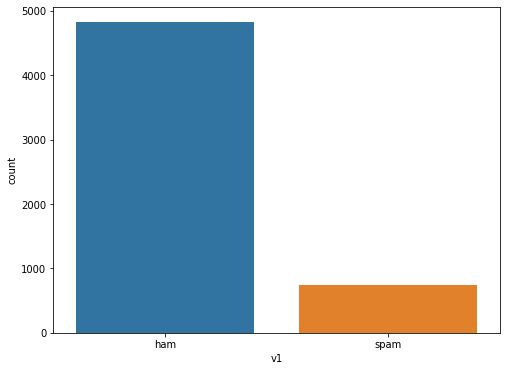

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(new_df.v1)
# Percentage of spam messages
#(len(spam_msg)/len(ham_msg))*100

In [ ]:
ham_msg = new_df[new_df.v1 =='ham']
spam_msg = new_df[new_df.v1=='spam']

In [ ]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

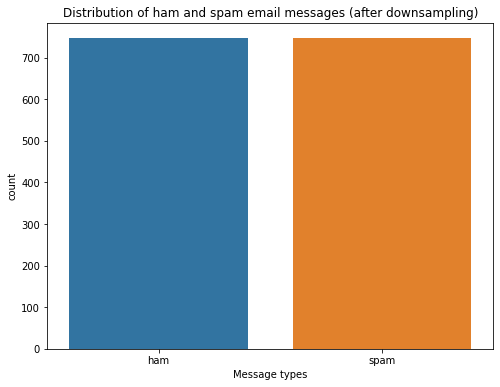

In [ ]:
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.v1)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [ ]:
msg_df['text_length'] = msg_df['v2'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('v1').mean()
labels

,text_length
v1,
ham,44.510040
spam,106.481928


In [ ]:
msg_df['msg_type']= msg_df['v1'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['v2'], msg_label, test_size=0.2, random_state=434)
print(len(train_msg))
print(len(test_msg))

1195
299


In [ ]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = None

In [ ]:
tokenizer = Tokenizer(num_words =None , char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)
word_index = tokenizer.word_index
print(word_index)
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

{'<OOV>': 1, 'call': 2, 'u': 3, 'free': 4, '2': 5, 'ur': 6, 'txt': 7, '4': 8, 'text': 9, 'get': 10, 'mobile': 11, 'stop': 12, 'claim': 13, 'reply': 14, 'send': 15, 'im': 16, 'prize': 17, 'new': 18, 'go': 19, 'dont': 20, 'please': 21, 'nokia': 22, 'win': 23, 'cash': 24, 'phone': 25, 'know': 26, 'want': 27, 'urgent': 28, 'service': 29, 'week': 30, 'contact': 31, 'good': 32, 'tone': 33, 'per': 34, 'customer': 35, '16': 36, 'day': 37, 'guaranteed': 38, 'time': 39, 'love': 40, 'ok': 41, 'ltgt': 42, '18': 43, 'hi': 44, 'draw': 45, 'like': 46, 'number': 47, 'got': 48, 'r': 49, 'chat': 50, 'line': 51, 'awarded': 52, 'every': 53, 'see': 54, '1': 55, 'back': 56, 'dear': 57, 'å1000': 58, 'msg': 59, 'come': 60, 'receive': 61, 'camera': 62, 'message': 63, 'holiday': 64, 'take': 65, 'mins': 66, 'chance': 67, '3': 68, 'one': 69, 'c': 70, 'latest': 71, 'tell': 72, 'shows': 73, 'live': 74, '150ppm': 75, 'po': 76, 'box': 77, 'great': 78, 'need': 79, 'yes': 80, 'å2000': 81, 'award': 82, 'find': 83, '1st'

In [ ]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [ ]:
len(training_sequences[0]), len(training_sequences[1])
#len(training_padded[0]), len(training_padded[1])

(16, 19)

In [ ]:
len(training_padded[0]), len(training_padded[1])


(50, 50)

In [ ]:
print(training_padded[0])

[1106   11  538  655  160   71  220   62   11    4    2   11  160  819
    4 1760    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
len(word_index)

4046

In [ ]:
vocab_size =len(word_index)+1 #added +1 here
embeding_dim = 16
n_lstm = 20  #dimensionality of the output space (no of output nodes)
drop_lstm =0.2 


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)) #return sequence set to true as the next lstm layer needs sequential input 
model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=False))  #return sequence set to false as the next dense layer only needs a single output and no the whole sequence 
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            64752     
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 71,013
Trainable params: 71,013
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
training_padded.shape #same as the length of training set (no of sequences)

(1195, 50)

In [ ]:
#generating a random array of values apart from training set and using it to check the shape of output given by the prediction
model.predict(np.random.rand(1,50)).shape


(1, 1)

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6922 - val_accuracy: 0.7525 - 5s/epoch - 132ms/step
Epoch 2/30
38/38 - 1s - loss: 0.5285 - accuracy: 0.7548 - val_loss: 0.2186 - val_accuracy: 0.9498 - 1s/epoch - 28ms/step
Epoch 3/30
38/38 - 1s - loss: 0.1766 - accuracy: 0.9582 - val_loss: 0.1874 - val_accuracy: 0.9498 - 1s/epoch - 28ms/step
Epoch 4/30
38/38 - 1s - loss: 0.0841 - accuracy: 0.9841 - val_loss: 0.2227 - val_accuracy: 0.9431 - 1s/epoch - 28ms/step
Epoch 5/30
38/38 - 1s - loss: 0.0559 - accuracy: 0.9916 - val_loss: 0.1770 - val_accuracy: 0.9565 - 1s/epoch - 28ms/step
Epoch 6/30
38/38 - 1s - loss: 0.0801 - accuracy: 0.9841 - val_loss: 0.2910 - val_accuracy: 0.9264 - 1s/epoch - 28ms/step
Epoch 7/30
38/38 - 1s - loss: 0.0872 - accuracy: 0.9766 - val_loss: 0.1839 - val_accuracy: 0.9398 - 1s/epoch - 28ms/step


In [ ]:
pd.options.display.max_colwidth=100
new_df[:3]

,v1,v2
0,ham,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...


In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

array([[0.0280531 ],
       [0.02782118],
       [0.9904642 ]], dtype=float32)

In [ ]:
predict_msg = ["COngratulations you have won a lottery worth 10k dollars. Call on 9576901-11182 to claim your prize",
               "Hi. My name is Ananya. I study in Mukesh patel college of engineering.",
          "What's up?"]
predict_spam(predict_msg)

array([[0.990089  ],
       [0.02925703],
       [0.02784169]], dtype=float32)

As observed from above, the model has quite correctly classified the first message as spam (99%) and the other two as ham